In [2]:
pip install hyperas==0.4.1

In [2]:
pip install -q tf-nightly

     |████████████████████████████████| 517.9MB 29kB/s 
     |████████████████████████████████| 3.0MB 33.7MB/s 
     |████████████████████████████████| 460kB 50.7MB/s 


In [3]:
#pip install hyperas==0.4.1
import time
from __future__ import print_function
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

import imutils
import cv2
from PIL import Image
import PIL

import os
from os import makedirs
from os.path import exists, join

import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import numpy as np

import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import vgg16, inception_v3, resnet50, mobilenet

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.models import Model
from keras import layers
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model


from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import merge, Input

from keras.regularizers import l1,l2,l1_l2

from joblib import load,dump
from sklearn.metrics import accuracy_score, confusion_matrix


Using TensorFlow backend.


In [0]:
### tensor board
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from google.protobuf import struct_pb2
from keras.callbacks import TensorBoard
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
from sklearn.metrics import f1_score
import sklearn.metrics as metrics

In [0]:
train_dir = "/content/drive/My Drive/Colab Notebooks/Dataset_Gan1/New_Train/"
validate_dir = "/content/drive/My Drive/Colab Notebooks/Dataset_Gan1/New_Val/"
test_dir =  "/content/drive/My Drive/Colab Notebooks/Dataset_Gan1/New_Test/"

In [0]:
def lableling_data(dir_path):
    X = []
    y = []
    i = 0
    
    # for loop is find all files in dir_path
    for path in (sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file) # cv2.imread --> load image
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    return X, y

In [9]:
X_train, y_train = lableling_data(train_dir)
X_test, y_test = lableling_data(test_dir)
X_val, y_val = lableling_data(validate_dir)

print('Train X--', X_train.shape,'y --', y_train.shape  )
print('Test X--', X_test.shape,'y --', y_test.shape  )
print('Validation X--', X_val.shape,'y --', y_val.shape  )

Train X-- (233,) y -- (233,)
Test X-- (38, 200, 200, 3) y -- (38,)
Validation X-- (39, 200, 200, 3) y -- (39,)


In [10]:
print("Total number images in Positive Train set",len([name for name in os.listdir(train_dir+'/YES') if os.path.isfile(os.path.join(train_dir+'/YES', name))])) 
print("Total number images in Positive Validation set",len([name for name in os.listdir(validate_dir+'/YES') if os.path.isfile(os.path.join(validate_dir+'/YES', name))])) 
print("Total number images in Positive Test set",len([name for name in os.listdir(test_dir+'/YES') if os.path.isfile(os.path.join(test_dir+'/YES', name))])) 

print('=='*25)

print("Total number images in Negative Train set",len([name for name in os.listdir(train_dir+'/NO') if os.path.isfile(os.path.join(train_dir+'/NO', name))])) 
print("Total number images in Negative Validation set",len([name for name in os.listdir(validate_dir+'/NO') if os.path.isfile(os.path.join(validate_dir+'/NO', name))])) 
print("Total number images in Negative Test set",len([name for name in os.listdir(test_dir+'/NO') if os.path.isfile(os.path.join(test_dir+'/NO', name))]))

Total number images in Positive Train set 145
Total number images in Positive Validation set 24
Total number images in Positive Test set 23
Total number images in Negative Train set 88
Total number images in Negative Validation set 15
Total number images in Negative Test set 15


In [92]:
img_width, img_height = 200, 200

train_dir = "/content/drive/My Drive/Colab Notebooks/Dataset/New_Train/"
validate_dir = "/content/drive/My Drive/Colab Notebooks/Dataset/New_Val/"
nb_train_samples = 400
nb_validation_samples = 100
epochs = 15
batch_size = 16

if K.image_data_format() == 'channels_first': 
	input_shape = (3, img_width, img_height) 
else: 
	input_shape = (img_width, img_height, 3) 

model = Sequential() 
model.add(Conv2D(32, (2, 2), input_shape = input_shape)) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size =(2, 2))) 

model.add(Conv2D(32, (2, 2))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size =(2, 2))) 

model.add(Conv2D(64, (2, 2))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size =(2, 2))) 

model.add(Flatten()) 
model.add(Dense(64)) 
model.add(Activation('relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(1)) 
model.add(Activation('sigmoid')) 

model.compile(loss ='binary_crossentropy', 
					optimizer ='rmsprop', 
				metrics =['accuracy']) 

train_datagen = ImageDataGenerator( 
				rescale = 1. / 255, 
				shear_range = 0.2, 
				zoom_range = 0.2, 
			horizontal_flip = True) 

test_datagen = ImageDataGenerator(rescale = 1. / 255) 

train_generator = train_datagen.flow_from_directory(train_dir, 
							target_size =(img_width, img_height), 
					batch_size = batch_size, class_mode ='binary') 

validation_generator = test_datagen.flow_from_directory( 
									validate_dir , 
				target_size =(img_width, img_height), 
		batch_size = batch_size, class_mode ='binary') 

history=model.fit_generator(train_generator, 
	steps_per_epoch = nb_train_samples // batch_size, 
	epochs = epochs, 
	validation_data = validation_generator, 
	validation_steps = nb_validation_samples // batch_size) 



Found 176 images belonging to 2 classes.
Found 39 images belonging to 2 classes.
Epoch 1/15
25/25 [==============================] - 4s 170ms/step - loss: 0.7058 - accuracy: 0.6425 - val_loss: 0.5322 - val_accuracy: 0.7949
Epoch 2/15
25/25 [==============================] - 4s 160ms/step - loss: 0.6042 - accuracy: 0.6775 - val_loss: 0.5016 - val_accuracy: 0.7692
Epoch 3/15
25/25 [==============================] - 4s 164ms/step - loss: 0.5938 - accuracy: 0.7075 - val_loss: 0.5394 - val_accuracy: 0.8462
Epoch 4/15
25/25 [==============================] - 4s 160ms/step - loss: 0.5626 - accuracy: 0.7375 - val_loss: 0.3489 - val_accuracy: 0.8974
Epoch 5/15
25/25 [==============================] - 4s 165ms/step - loss: 0.5332 - accuracy: 0.7600 - val_loss: 0.4117 - val_accuracy: 0.8462
Epoch 6/15
25/25 [==============================] - 4s 156ms/step - loss: 0.4501 - accuracy: 0.7850 - val_loss: 0.3964 - val_accuracy: 0.7949
Epoch 7/15
25/25 [==============================] - 4s 165ms/step -

# **To Plot the Confusion Matrix**

In [0]:
import pandas as pd
import seaborn as sns


def plotErrorGraph(history, ep=30):

    # Making the plot larger
    plt.figure(figsize=(12, 8))

    loss = history.history['loss']                          # Loss on the training data
    val_loss = history.history['val_loss']                  # Loss on the validation data
    epochs = range(1, ep+1)

    plt.plot(epochs, loss, 'ro-', label='Training Loss')
    plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
    plt.legend()
    
    
def plotConfusionMatrix(y_test,pred):

    pred = [1 if x>0.5 else 0 for x in pred]

    # calculate confusion matrix
    cm =  confusion_matrix(y_test,pred)
    class_label = ['negative', 'positive']
    df_conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
    # heatmap --> Plot rectangular data as a color-encoded matrix. 
    sns.heatmap(df_conf_matrix, annot=True, fmt='d')
    # give title to graph
    plt.title("Confusion Matrix")
    # mention axis label
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    # show the plot
    plt.show()
    print('TN = ', cm[0][0])
    print('FP = ', cm[0][1])
    print('FN = ', cm[1][0])
    print('TP = ', cm[1][1])



def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


38/38 [==============================] - 0s 716us/step


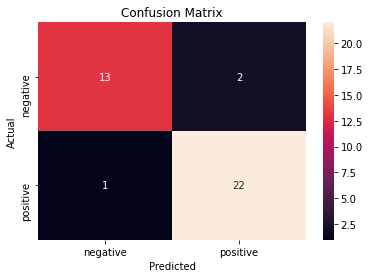

TN =  13
FP =  2
FN =  1
TP =  22


In [94]:
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=10, verbose=1)

#print(" accuracy: {:.4f}%".format(loss,accuracy * 100))

pred = model.predict(X_test)
plotConfusionMatrix(y_test,pred)



In [0]:
TN =  13
FP =  2
FN =  1
TP =  22

## **Sensitivity**  :  When the actual value is positive, how often is the prediction correct?

Also Known as True positive rate. 

In [96]:
sensitivity = (TP / float(FN + TP))*100

print(sensitivity)


95.65217391304348


## **Specificity** :  the actual value is negative, how often is the prediction correct?

Also known as True Negative Rate

In [97]:
specificity = (TN / (TN + FP))*100

print(specificity)

86.66666666666667


# **Accuracy**

In [98]:
Accuracy = ( (TP+TN) / (TP+TN+FP+FN) ) * 100
print(Accuracy)

92.10526315789474


# **Efficiency**

In [99]:
Efficiency = ( sensitivity + specificity + Accuracy ) / 3
print(Efficiency)

91.4747012458683


## **Plot Loss & Accuracy**

In [0]:
history = model.history.history

In [101]:
for key in history.keys():
    print(key)

val_loss
val_accuracy
loss
accuracy


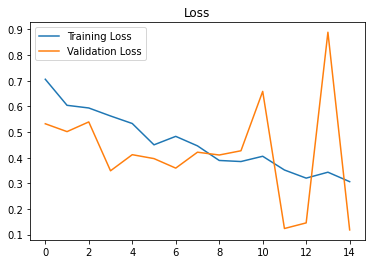

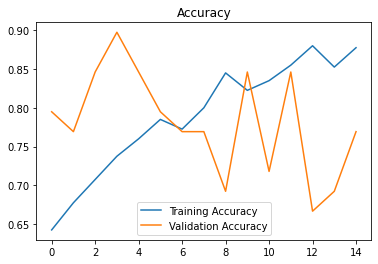

In [102]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history)

## **Test Accuracy**



In [103]:
loss, acc = model.evaluate(x=X_test, y=y_test)

38/38 [==============================] - 0s 905us/step


In [104]:
print (f"Test Accuracy = {acc}")

Test Accuracy = 0.9210526347160339


# **Calculation of f1 score** 

In [0]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# ***F1 score for the model on the testing data*** 

In [0]:
y_test_prob = model.predict(X_test)

In [107]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9361702127659574


# ***F1 score for the  model on the validation data***

In [0]:
y_val_prob = model.predict(X_val)

In [109]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8444444444444444


# **Prediction**

In [110]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('/content/drive/My Drive/Colab Notebooks/Dataset/YES/img100.png', target_size = (200,200))
test_image.show()
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)
train_generator.class_indices
if result[0][0] == 1:
  prediction = 'YES'
else:
  prediction = 'NO'

print(prediction)

[[1.]]
YES
